In [2201]:
# Modules de base
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd 

# Module relatif à Gurobi
from gurobipy import *

# Module csv
import csv

## Importation des données

In [2202]:
# Instance_file : str
Instance_file = "InstanceBordeauxV1.xlsx"

# Chargement des donnees
Employees = pd.read_excel(Instance_file, sheet_name= 'Employees')
Tasks = pd.read_excel(Instance_file, sheet_name= 'Tasks')
Employees_Unavailabilities = pd.read_excel(Instance_file, sheet_name= 'Employees Unavailabilities')
Tasks_Unavailabilities = pd.read_excel(Instance_file, sheet_name= 'Tasks Unavailabilities')

print(Employees)
#print(Tasks)

  EmployeeName   Latitude  Longitude     Skill  Level WorkingStartTime  \
0     Valentin  45.151218  -0.822093  Oenology      2           7:00am   
1        Ambre  45.199575  -0.822093  Oenology      1           8:00am   

  WorkingEndTime  
0         5:00pm  
1         6:00pm  


## Création des dictionnaires de paramètres

Listes des dictionnaires de paramètres à créer:
- LevelEmployee[i] qui à un employé i lui associe son niveau de compétence
- BeginningEmployee[i] qui à un employé i lui associe son début de journée de travail
- EndEmployee[i] qui à un employé i lui associe sa fin de journée de travail
- LevelTask[j] qui à une tâche j lui associe son niveau de difficulté
- BeginningTask[j] qui à une tâche j lui aussi le début du créneau durant lequel on peut l'effectuer
- EndTask[j] qui à une tâche j lui aussi la fin du créneau durant lequel on peut l'effectuer
- DurationTask[j] qui à une tâche j lui associe sa durée
- TasksUnavailabilities[j]
- DistDict[i][j] dictionnaire contenant les distances entre toutes les tâches et les domiciles des employées
- TimeDict[i][j] dictionnaire contenant les temps de trajet associés
- Unavailability[l]: recense les indisponibilités sous forme (employe, debutindispo, duree)

In [2203]:
#Paramètres
N = len(Employees["EmployeeName"])
K = len(Tasks["TaskId"])
L = len(Employees_Unavailabilities["EmployeeName"])



LevelEmployee = dict()

for i in range (len(Employees["EmployeeName"])):
    a = Employees["EmployeeName"][i]
    b = Employees["Level"][i]
    LevelEmployee[i+1] = b

#print(LevelEmployee)

BeginningEmployee = dict()

for i in range (len(Employees["EmployeeName"])):
    a = Employees["EmployeeName"][i]
    b = Employees["WorkingStartTime"][i][:1]
    bg = b[:2]   #prend les deux premiers caractères
    bd = b[-3:]
    if bg[-1:] == ":":  #cas où l'heure n'a qu'un chiffre
        b = int(b[:1]) + int(bd[:2]) *100/60
        
    if bg[-1:] != ":":
        b = int(b[:2]) + int(bd[-2:]) *100/60

    if Employees["WorkingStartTime"][i][-2:] == 'am':
        BeginningEmployee[a] = b
    if Employees["WorkingStartTime"][i][2:] == "pm":
        BeginningEmployee[a] = b + 12

#print(BeginningEmployee)

EndEmployee = dict()

for i in range (len(Employees["EmployeeName"])):
    a = Employees["EmployeeName"][i]
    b = Employees["WorkingEndTime"][i][:1]
    bg = b[:2]   #prend les deux premiers caractères
    bd = b[-3:]
    if bg[-1:] == ":":  #cas où l'heure n'a qu'un chiffre
        b = int(b[:1]) + int(bd[:2]) *100/60
        
    if bg[-1:] != ":":
        b = int(b[:2]) + int(bd[-2:]) *100/60

    if Employees["WorkingEndTime"][i][-2:] == 'am':
        EndEmployee[a] = b
    if Employees["WorkingEndTime"][i][2:] == "pm":
        EndEmployee[a] = b + 12

#print(EndEmployee)

LevelTask = dict()

for i in range (len(Tasks["TaskId"])):
    a = i+1
    b = Tasks["Level"][i]
    LevelTask[a] = b

#print(LevelTask)

TasksUnavailabilities = dict()

for i in range (len(Tasks_Unavailabilities["TaskId"])):
    a = Tasks_Unavailabilities["TaskId"][i] 
    b = Tasks_Unavailabilities["Start"][i][:5]
    bg = b[:2]   #prend les deux premiers caractères
    bd = b[-3:]
    if bg[-1:] == ":":  #cas où l'heure n'a qu'un chiffre
        b = int(b[:1]) + int(bd[:2]) *100/60
        
    if bg[-1:] != ":":
        b = int(b[:2]) + int(bd[-2:]) *100/60
        
    c = Tasks_Unavailabilities["End"][i][:5]
    cg = c[:2]   #prend les deux premiers caractères
    cd = c[-3:]
    if cg[-1:] == ":":  #cas où l'heure n'a qu'un chiffre
        c = int(c[:1]) + int(cd[:2]) *100/60
        
    if cg[-1:] != ":":
        c = int(c[:2]) + int(cd[-2:]) *100/60

    if Tasks_Unavailabilities["Start"][i][-2:] == 'pm' and b!=12:
        b = b + 12
    if Tasks_Unavailabilities["End"][i][2:] == "pm" and c!=12:
        c = c + 12
    TasksUnavailabilities[a] = [b,c]

#print(TasksUnavailabilities)

Unavailability = dict()

for i in range (len(Employees_Unavailabilities["EmployeeName"])):
    for k in range (len(Employees["EmployeeName"])):
        if Employees_Unavailabilities["EmployeeName"][i] == Employees["EmployeeName"][k]:
            a = k + 1
    b = Employees_Unavailabilities["Start"][i][:5]
    bg = b[:2]   #prend les deux premiers caractères
    bd = b[-3:]
    if bg[-1:] == ":":  #cas où l'heure n'a qu'un chiffre
        b = int(b[:1]) + int(bd[:2]) *100/60
        
    if bg[-1:] != ":":
        b = int(b[:2]) + int(bd[-2:]) *100/60
        
    c = Employees_Unavailabilities["End"][i][:5]
    cg = c[:2]   #prend les deux premiers caractères
    cd = c[-3:]
    if cg[-1:] == ":":  #cas où l'heure n'a qu'un chiffre
        c = int(c[:1]) + int(cd[:2]) *100/60
        
    if cg[-1:] != ":":
        c = int(c[:2]) + int(cd[-2:]) *100/60
    if Employees_Unavailabilities["Start"][i][-2:] == 'pm'and b!=12:
        b = int(b) + 12
    if Employees_Unavailabilities["End"][i][2:] == "pm" and c!=12:
        c = int(c) + 12 - b
    Unavailability[i+1] = [a,b,c]

#print(Unavailability)


BeginningTask = dict()

for i in range(K+L+2*N): 
    if i < L:
        a = Employees_Unavailabilities["EmployeeName"][i]
        b = Employees_Unavailabilities["Start"][i][:5]
        c = Employees_Unavailabilities["Start"][i] 

    if i >= L and i < L+K:
        a = Tasks["TaskId"][i-L]
        b = Tasks["OpeningTime"][i-L][:5]
        c = Tasks["OpeningTime"][i-L]
    if i >= L+K and i < L+K+N:
        a = Employees["EmployeeName"][i-L-K]
        b = Employees["WorkingStartTime"][i-L-K][:5]
        c = Employees["WorkingStartTime"][i-L-K]
    if i >= L+K+N:
        a = Employees["EmployeeName"][i-L-K-N]
        b = Employees["WorkingEndTime"][i-L-K-N][:5]
        c = Employees["WorkingEndTime"][i-L-K-N]

    ### conversion sous format decimal 12:30 => 12,5
    bg = b[:2]   #prend les deux premiers caractères
    bd = b[-3:]
    if bg[-1:] == ":":  #cas où l'heure n'a qu'un chiffre
        b = int(b[:1]) + int(bd[:2]) *100/60
        
    if bg[-1:] != ":":
        b = int(b[:2]) + int(bd[-2:]) *100/60
        
    if c[-2:] == 'am':
        if bg != '12':
            #BeginningTask[a] = b
            BeginningTask[i+1] = b
        else:
            BeginningTask[i+1] = b - 12   
    if c[-2:] == "pm":
        if bg != '12':
            #BeginningTask[a] = b + 12
            BeginningTask[i+1] = b + 12
        else:
            BeginningTask[i+1] = b


#print(BeginningTask)


EndTask = dict()

for i in range (0,K+L+2*N): 
    if i < L:
        a = Employees_Unavailabilities["EmployeeName"][i]
        b = Employees_Unavailabilities["End"][i][:5]
        c = Employees_Unavailabilities["End"][i]
    if i >= L and i < L+K:
        a = Tasks["TaskId"][i-L]
        b = Tasks["ClosingTime"][i-L][:5]
        c = Tasks["ClosingTime"][i-L]
    if i >= L+K and i < L+K+N:
        a = Employees["EmployeeName"][i-L-K]
        b = Employees["WorkingStartTime"][i-L-K][:5]
        c = Employees["WorkingStartTime"][i-L-K]
    if i >= L+K+N:
        a = Employees["EmployeeName"][i-L-K-N]
        b = Employees["WorkingEndTime"][i-L-K-N][:5]
        c = Employees["WorkingEndTime"][i-L-K-N]
    bg = b[:2]   #prend les deux premiers caractères
    bd = b[-3:]
    
    if bg[-1:] == ":":  #cas où l'heure n'a qu'un chiffre
        b = int(b[:1]) + int(bd[:2]) *100/60
        
    if bg[-1:] != ":":
        b = int(b[:2]) + int(bd[-2:]) *100/60
        
    if c[-2:] == 'am':
        if bg != '12':
            #BeginningTask[a] = b
            EndTask[i+1] = b
        else:
            EndTask[i+1] = b - 12   
    if c[-2:] == "pm":
        if bg != '12':
            #EndTask[a] = b + 12
            EndTask[i+1] = b + 12
        else:
            EndTask[i+1] = b

#print(EndTask)


DurationTask = dict()
for i in range (L):
    a = i + 1
    b = Unavailability[i+1][2]
    DurationTask[a] = b
for i in range (K):
    a = L + i + 1
    b = Tasks["TaskDuration"][i] / 60
    DurationTask[a] = b

for i in range (N):
    a = L + K + i + 1
    b = 0
    DurationTask[a] = b
    DurationTask[a+N] = b

print(DurationTask)

Position = dict()   # contient les positions des tâches indispo

for i in range (L+K+2*N):
    if i < L:
        L_i = Employees_Unavailabilities["Longitude"][i]
        l_i = Employees_Unavailabilities["Latitude"][i]
    if i >= L and i < L+K:
        L_i = Tasks["Longitude"][i-L]
        l_i = Tasks["Latitude"][i-L]
    if i >= L+K and i < L+K+N:
        L_i = Employees["Longitude"][i-L-K]
        l_i = Employees["Latitude"][i-L-K]
    if i >= L+K+N :
        L_i = Employees["Longitude"][i-L-K-N]
        l_i = Employees["Latitude"][i-L-K-N]
    Position[i+1] = [L_i, l_i]

        


##Création du dictionnaire des distances
#DistDic: associe à (i,j) la distance entre les deux tâches

DistDict = dict()
R = 6371  #rayon de la Terre

for i in range (1,L+K+2*N+1):               ## ajout des distances entre tasks
    for k in range (1,L+K+2*N+1):
            L_i = Position[i][0]
            l_i = Position[i][1]
            L_k = Position[k][0]
            l_k = Position[k][1]
            A = np.sin((l_i-l_k)*np.pi/(2*180))**2
            B = (np.sin((L_i-L_k)*np.pi/(2*180))**2)*np.cos(l_i*np.pi/180)*np.cos(l_k*np.pi/180)
            d = 2*R*np.sqrt(A+B)
            DistDict[(i,k)] = d


#print(DistDict)

##Création dictionnaire des temps de trajet

# TimeDict : associe à un trajet (i,j) le temps de trajet en h


#TimeDict = dict()

for element in DistDict.items():
    t = element[1] / 50
    TimeDict[element[0]] = t

#print(TimeDict)


{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.25, 11: 1.0, 12: 0, 14: 0, 13: 0, 15: 0}


## Modules

In [2204]:
# Modules de base
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# Module relatif à Gurobi
from gurobipy import *

## Données

In [2205]:
# number_of_employees : int
N=len(Employees)

# number_of_tasks : int
K=len(Tasks)

# number_of_unavailabilities : int
L=len(Unavailability)



## Variables

In [2206]:
# -- Initialisation du modèle --
# m : Model
m = Model("ProjetST7")

# -- Ajout des variables  --
# X: dict[(int, int) : Var]
X = {(i,j) : m.addVar(vtype = GRB.BINARY, name = f'employeetask{i}_{j}') for i in range(1, N+1) for j in range(1,K+L+2*N+1)}

# T : dict[int : Var]
T = {(j) : m.addVar(vtype = GRB.CONTINUOUS, name=f'begintask_{j}') for j in range(1, K+L+2*N+1)}

# Y: dict[(int, int) : Var]
Y = {(i,j) : m.addVar(vtype = GRB.BINARY, name = f'successivetask{i}_{j}') for i in range(1, K+L+2*N+1) for j in range(1,K+L+2*N+1)}

## Contraintes

- Un employé pour une tâche

In [2207]:
# OneEmployeePerTaskConstrDict : dict[int : Constr]
OneEmployeePerTaskConstrDict = {j : m.addConstr(quicksum([X[(i, j)] for i in range(1, N + 1)]) == 1, name = f'one_employee_per_task{j}') for j in range(1, L+K+2*N + 1)}

- Niveau de l'employé suffisant pour la tâche

In [2208]:
# MinimumLevelConstrDict : dict[(int,int) : Constr]
MinimumLevelConstrDict = {(i,j) : m.addConstr(LevelTask[j]*X[(i,j)] <= LevelEmployee[i]  , name = f'level_{i}_{j}') for i in range(1, N + 1) for j in range(L+1,L+K) }

- Début et fin de chaque tâche

In [2209]:
# StartConstrDict : dict[(int,int) : Constr]
StartConstrDict = {j : m.addConstr(T[j] >= BeginningTask[j], name = f'start_{j}') for j in range(1,K+L+2*N+1) }
EndConstrDict = {j : m.addConstr(T[j]+DurationTask[j]<=EndTask[j], name = f'end_{j}') for j in range(1,K+L+2*N+1) }

- Délai entre 2 tâches successives

In [2210]:
M=10000
SuccessiveTasksGapConstrDict = {(i,j) : m.addConstr((T[j]-T[i]) - (Y[(i,j)]*(DurationTask[i]+TimeDict[(i,j)])+(1-Y[(i,j)])*(-M)) >= 0 , name = f'successivetaksgap_{i}_{j}') for i in range(1, K+L+2*N+1) for j in range(1, K+L+2*N+1) if i!=j }
#SuccessiveTasksGapConstrDict = {(i,j) : m.addConstr((T[j]-T[i]) - (Y[(i,j)]*(DurationTask[i]+TimeDict[(i,j)])+(1-Y[(i,j)])*(-M)) >= 0 , name = f'successivetaksgap_{i}_{j}') for i in range(1, K+L+2*N+1) for j in range(1,K+L+2*N+1) if (i,j) in DistDict.keys() }


- Une seule tâche succède à une autre

In [2211]:
#contrainte d'entrée/sortie
OneTaskAfterAnother1ConstrDict = {j : m.addConstr(quicksum(Y[(k,j)] for k in range(1,K+L+2*N+1)) == 1, name = f'OneTaskAfterAnother1_{j}') for j in range(K+L+N+1, K+L+2*N+1) if j!=k}
OneTaskAfterAnother2ConstrDict = {j : m.addConstr(quicksum(Y[(j,k)] for k in range(1,K+L+2*N+1)) == 1, name = f'OneTaskAfterAnother2_{j}') for j in range(K+L+1, K+L+N+1) if j!=k}

#contrainte de flot
OneTaskAfterAnother3ConstrDict = {j : m.addConstr(quicksum(Y[(j,k)] for k in range(1,K+L+2*N+1)) - quicksum(Y[(k,j)] for k in range(1,K+L+2*N+1)) == 0 , name = f'OneTaskAfterAnother3_{j}') for j in range(1,K+L+1) }
OneTaskAfterAnother4ConstrDict = {j : m.addConstr(quicksum(Y[(k,j)] for k in range(1,K+L+2*N+1)) == 1, name = f'OneTaskAfterAnother4_{j}') for j in range(L+1, K+L+1) }
OneTaskAfterAnother5ConstrDict = {j : m.addConstr(quicksum(Y[(j,k)] for k in range(1,K+L+2*N+1)) == 1, name = f'OneTaskAfterAnother5_{j}') for j in range(L+1, K+L+1) }
#ontrainte sur les indispos
OneTaskAfterAnother6ConstrDict = {j : m.addConstr(quicksum(Y[(k,j)] for k in range(1,K+L+2*N+1)) == 1, name = f'OneTaskAfterAnother6_{j}') for j in range(1, L+1) }
OneTaskAfterAnother7ConstrDict = {j : m.addConstr(quicksum(Y[(j,k)] for k in range(1,K+L+2*N+1)) == 1, name = f'OneTaskAfterAnother7_{j}') for j in range(1, L+1) }

TwoSuccessivesTasksCantBeTheSame = {j : m.addConstr(Y[(j,j)]==0) for j in range(1,K+L+2*N+1) }

- Si deux tâches sont successives il existe k tel que ces tâches sont effectuées par le même employé

In [2212]:
#SuccessiveTasksOneEmployee1ConstrDict = {(i,j,k) : m.addConstr(1-Y[(i,j)]-(X[(k,i)]-X[(k,j)])>=0 , name = f'successivetaksoneemployee1_{i}_{j}_{k}') for i in range(1, K+L+1) for j in range(1, K+L+1) for k in range(1,N+1) }
#SuccessiveTasksOneEmployee2ConstrDict = {(i,j,k) : m.addConstr(1-Y[(i,j)]+(X[(k,i)]-X[(k,j)])>=0 , name = f'successivetaksoneemployee2_{i}_{j}_{k}') for i in range(1, K+L+1) for j in range(1, K+L+1) for k in range(1,N+1) }
#SuccessiveTasksOneEmployee3ConstrDict = {(i,j,k) : m.addConstr(1-Y[(i,j)]+(X[(k,i)]-X[(k,j)])>=0 , name = f'successivetaksoneemployee3_{i}_{j}_{k}') for i in range(1, L+1) for j in range(1,L+1) for k in range(1,N+1) }
#idée pour empêcher qu'un employé qui ne fait aucune tâche ne fasse pas le chemin entre les deux
#SuccessiveTasksOneEmployee4ConstrDict = {(i,j,k) : m.addConstr( Y[(i,j)]-(X[(k,i)]+X[(k,j)])/2 <=0 , name = f'successivetaksoneemployee4_{i}_{j}_{k}') for i in range(1, L+1) for j in range(1,L+1) for k in range(1,N+1) }

- Contrainte d'attribution des indisponibilités et départ/retour au domicile aux bons employés

In [2213]:
UnavailabilityConstr = {i : m.addConstr( X[(Unavailability[i][0], i)] == 1 , name = f'unavailabilityemployee_{i}') for i in range(1,L+1) }
HomeDepartureConstr = {i : m.addConstr( X[(i, L+K+i)] == 1 , name = f'homedepartureemployee_{i}') for i in range(1,N+1) }
HomeReturnConstr = {i : m.addConstr( X[(i, L+K+N+i)] == 1 , name = f'homereturnemployee_{i}') for i in range(1,N+1) }

- Fixer heure debut indispo

In [2214]:
UnavailabilityTimeConstr = {i : m.addConstr( T[i] - BeginningTask[i] == 0 , name = f'unavailabilitytimeemployee_{i}') for i in range(1,L+1)}

## Fonction Objectif

In [2215]:
# -- Ajout de la fonction objectif --
#m.setObjective(quicksum(Y[(i,j)]*TimeDict[(i,j)] for i in range (1,K+L+2*N+1) for j in range (1,K+L+2*N+1) if (i,j)  in DistDict.keys() ), GRB.MINIMIZE)
m.setObjective(quicksum(Y[(i,j)]*TimeDict[(i,j)] for (i,j)  in DistDict.keys() ), GRB.MINIMIZE)


In [2216]:
# -- Choix d'un paramétrage d'affichage minimaliste --
m.params.outputflag = 0 # mode muet

# -- Mise à jour du modèle  --
m.update()

print(m.status)
# -- Résolution --
m.optimize()



1


In [2217]:
print(m.ObjVal)

4.799658595996695


In [2218]:
print(X)

{(1, 1): <gurobi.Var employeetask1_1 (value 0.0)>, (1, 2): <gurobi.Var employeetask1_2 (value -0.0)>, (1, 3): <gurobi.Var employeetask1_3 (value 1.0)>, (1, 4): <gurobi.Var employeetask1_4 (value -0.0)>, (1, 5): <gurobi.Var employeetask1_5 (value 1.0)>, (1, 6): <gurobi.Var employeetask1_6 (value 1.0)>, (1, 7): <gurobi.Var employeetask1_7 (value -0.0)>, (1, 8): <gurobi.Var employeetask1_8 (value -0.0)>, (1, 9): <gurobi.Var employeetask1_9 (value 1.0)>, (1, 10): <gurobi.Var employeetask1_10 (value -0.0)>, (1, 11): <gurobi.Var employeetask1_11 (value 1.0)>, (1, 12): <gurobi.Var employeetask1_12 (value 1.0)>, (1, 13): <gurobi.Var employeetask1_13 (value 0.0)>, (1, 14): <gurobi.Var employeetask1_14 (value 1.0)>, (1, 15): <gurobi.Var employeetask1_15 (value 0.0)>, (2, 1): <gurobi.Var employeetask2_1 (value 1.0)>, (2, 2): <gurobi.Var employeetask2_2 (value 1.0)>, (2, 3): <gurobi.Var employeetask2_3 (value 0.0)>, (2, 4): <gurobi.Var employeetask2_4 (value 1.0)>, (2, 5): <gurobi.Var employeetask

In [2219]:
for i in range(1,K+L+2*N+1):
    for j in range(1,K+L+2*N+1):
    
        print(Y[(i,j)])

<gurobi.Var successivetask1_1 (value 0.0)>
<gurobi.Var successivetask1_2 (value 1.0)>
<gurobi.Var successivetask1_3 (value -0.0)>
<gurobi.Var successivetask1_4 (value -0.0)>
<gurobi.Var successivetask1_5 (value -0.0)>
<gurobi.Var successivetask1_6 (value -0.0)>
<gurobi.Var successivetask1_7 (value -0.0)>
<gurobi.Var successivetask1_8 (value -0.0)>
<gurobi.Var successivetask1_9 (value 0.0)>
<gurobi.Var successivetask1_10 (value 0.0)>
<gurobi.Var successivetask1_11 (value -0.0)>
<gurobi.Var successivetask1_12 (value 0.0)>
<gurobi.Var successivetask1_13 (value 0.0)>
<gurobi.Var successivetask1_14 (value -0.0)>
<gurobi.Var successivetask1_15 (value -0.0)>
<gurobi.Var successivetask2_1 (value 0.0)>
<gurobi.Var successivetask2_2 (value 0.0)>
<gurobi.Var successivetask2_3 (value -0.0)>
<gurobi.Var successivetask2_4 (value -0.0)>
<gurobi.Var successivetask2_5 (value -0.0)>
<gurobi.Var successivetask2_6 (value 1.0)>
<gurobi.Var successivetask2_7 (value -0.0)>
<gurobi.Var successivetask2_8 (valu

In [2220]:
print(T)

{1: <gurobi.Var begintask_1 (value 12.0)>, 2: <gurobi.Var begintask_2 (value 13.706832173891598)>, 3: <gurobi.Var begintask_3 (value 10.517332649496893)>, 4: <gurobi.Var begintask_4 (value 15.861354836828509)>, 5: <gurobi.Var begintask_5 (value 13.586320568647393)>, 6: <gurobi.Var begintask_6 (value 15.923836690701137)>, 7: <gurobi.Var begintask_7 (value 14.736824214454868)>, 8: <gurobi.Var begintask_8 (value 12.161689355720268)>, 9: <gurobi.Var begintask_9 (value 9.128956325890613)>, 10: <gurobi.Var begintask_10 (value 8.274221654362918)>, 11: <gurobi.Var begintask_11 (value 8.0)>, 12: <gurobi.Var begintask_12 (value 7.0)>, 13: <gurobi.Var begintask_13 (value 8.0)>, 14: <gurobi.Var begintask_14 (value 17.0)>, 15: <gurobi.Var begintask_15 (value 18.0)>}


In [2221]:
m.getVars()

[<gurobi.Var employeetask1_1 (value 0.0)>,
 <gurobi.Var employeetask1_2 (value -0.0)>,
 <gurobi.Var employeetask1_3 (value 1.0)>,
 <gurobi.Var employeetask1_4 (value -0.0)>,
 <gurobi.Var employeetask1_5 (value 1.0)>,
 <gurobi.Var employeetask1_6 (value 1.0)>,
 <gurobi.Var employeetask1_7 (value -0.0)>,
 <gurobi.Var employeetask1_8 (value -0.0)>,
 <gurobi.Var employeetask1_9 (value 1.0)>,
 <gurobi.Var employeetask1_10 (value -0.0)>,
 <gurobi.Var employeetask1_11 (value 1.0)>,
 <gurobi.Var employeetask1_12 (value 1.0)>,
 <gurobi.Var employeetask1_13 (value 0.0)>,
 <gurobi.Var employeetask1_14 (value 1.0)>,
 <gurobi.Var employeetask1_15 (value 0.0)>,
 <gurobi.Var employeetask2_1 (value 1.0)>,
 <gurobi.Var employeetask2_2 (value 1.0)>,
 <gurobi.Var employeetask2_3 (value 0.0)>,
 <gurobi.Var employeetask2_4 (value 1.0)>,
 <gurobi.Var employeetask2_5 (value 0.0)>,
 <gurobi.Var employeetask2_6 (value 0.0)>,
 <gurobi.Var employeetask2_7 (value 1.0)>,
 <gurobi.Var employeetask2_8 (value 1.0)>,


In [2222]:
for v in m.getVars():
    print(f"{v.VarName} = {v.X}")

employeetask1_1 = 0.0
employeetask1_2 = -0.0
employeetask1_3 = 1.0
employeetask1_4 = -0.0
employeetask1_5 = 1.0
employeetask1_6 = 1.0
employeetask1_7 = -0.0
employeetask1_8 = -0.0
employeetask1_9 = 1.0
employeetask1_10 = -0.0
employeetask1_11 = 1.0
employeetask1_12 = 1.0
employeetask1_13 = 0.0
employeetask1_14 = 1.0
employeetask1_15 = 0.0
employeetask2_1 = 1.0
employeetask2_2 = 1.0
employeetask2_3 = 0.0
employeetask2_4 = 1.0
employeetask2_5 = 0.0
employeetask2_6 = 0.0
employeetask2_7 = 1.0
employeetask2_8 = 1.0
employeetask2_9 = 0.0
employeetask2_10 = 1.0
employeetask2_11 = 0.0
employeetask2_12 = 0.0
employeetask2_13 = 1.0
employeetask2_14 = 0.0
employeetask2_15 = 1.0
begintask_1 = 12.0
begintask_2 = 13.706832173891598
begintask_3 = 10.517332649496893
begintask_4 = 15.861354836828509
begintask_5 = 13.586320568647393
begintask_6 = 15.923836690701137
begintask_7 = 14.736824214454868
begintask_8 = 12.161689355720268
begintask_9 = 9.128956325890613
begintask_10 = 8.274221654362918
begintas

X0
{(1, 1): 0.0, (1, 2): -0.0, (1, 3): 1.0, (1, 4): -0.0, (1, 5): 1.0, (1, 6): 1.0, (1, 7): -0.0, (1, 8): -0.0, (1, 9): 1.0, (1, 10): -0.0, (1, 11): 1.0, (1, 12): 1.0, (1, 13): 0.0, (1, 14): 1.0, (1, 15): 0.0, (2, 1): 1.0, (2, 2): 1.0, (2, 3): 0.0, (2, 4): 1.0, (2, 5): 0.0, (2, 6): 0.0, (2, 7): 1.0, (2, 8): 1.0, (2, 9): 0.0, (2, 10): 1.0, (2, 11): 0.0, (2, 12): 0.0, (2, 13): 1.0, (2, 14): 0.0, (2, 15): 1.0}
T0
{1: 12.0, 2: 13.706832173891598, 3: 10.517332649496893, 4: 15.861354836828509, 5: 13.586320568647393, 6: 15.923836690701137, 7: 14.736824214454868, 8: 12.161689355720268, 9: 9.128956325890613, 10: 8.274221654362918, 11: 8.0, 12: 7.0, 13: 8.0, 14: 17.0, 15: 18.0}
Y0
{(1, 1): 0.0, (1, 2): 1.0, (1, 3): -0.0, (1, 4): -0.0, (1, 5): -0.0, (1, 6): -0.0, (1, 7): -0.0, (1, 8): -0.0, (1, 9): 0.0, (1, 10): 0.0, (1, 11): -0.0, (1, 12): 0.0, (1, 13): 0.0, (1, 14): -0.0, (1, 15): -0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): -0.0, (2, 4): -0.0, (2, 5): -0.0, (2, 6): 1.0, (2, 7): -0.0, (2, 8): -0.0, 

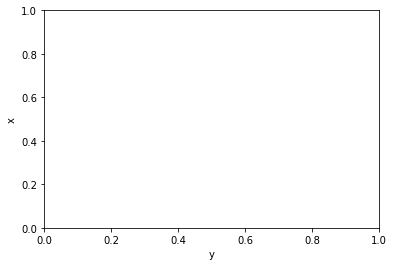

In [2223]:
#Extraction des sorties

routeindex = dict() #dictionnaire contenant les listes ordonnées des indices des taches réalisées associé à chque employé i (i étant la valeur de la clé)
routes = dict()   #contient les points de la route de chaque employé sous forme de liste de tuple (latitude,longitude)


X0 = dict()
Y0 = dict()
T0 = dict()

for i in range (1,N+1):
    for j in range(1, L + K + 2*N + 1):
        X0[(i,j)] = m.getVarByName(f'employeetask{i}_{j}').x


for j in range(1, L + K + 2*N + 1):
    T0[(j)] = m.getVarByName(f'begintask_{j}').x

for i in range (1, L + K + 2*N +1):
    for j in range(1, L + K + 2*N + 1):
        Y0[(i,j)] = m.getVarByName(f'successivetask{i}_{j}').x

print("X0")
print(X0)
print("T0")
print(T0)
print("Y0")
print(Y0)

for i in range (1, N+1):        #on va pour chaque employé retracer son trajet grâce à Y i_j
    a = Employees["EmployeeName"][i-1]
    routeIndiv = []
    m = K+L+i+1
    routeIndiv.append(m)
    while m!= K+L+N+i:
        for j in range (1, L+K+2*N+1):
            if  Y0[(m,j)] == 1 :   #à adapter pour que ça fonctionne avec Y variable du pb
                m = j
                routeIndiv.append(m)
        break
    routeindex[a] = routeIndiv   


for k in routeindex.keys():
    routes[k] = [(Position[i][0],Position[i][1]) for i in routeindex[k]]   #ensemble des points (longitude, Latitude) organisés en listes de trajet par employé  

#print(route)


#def plotRoute(route):
 #   xs = [task[0] for task in route] + [task[0][0]]
  #  ys = [task[1] for task in route] + [task[0][1]]
   # plt.plot(xs, ys, 'o-')


#for key in routes.keys():
#    plotRoute(routes[key])

plt.ylabel('x')
plt.xlabel('y')
plt.show()
